# Home Credit Default Risk


I created a complete pipeline to preprocess the data, then trained a model and then predicted values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## 1. Introduction

This is a binary Classification task: I want to predict whether the person applying for a home credit will be able to repay its debt or not.

The dataset is composed of multiple files with different information about loands taken. In this project I'm going to exclusively work with the main files: application_train.csv and application_test.csv.

I will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so my models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files:

- `application_train.csv`: Training dataset you must use to train and find the best hyperparameters on your model.
- `application_test.csv`: Test dataset, use it only when you are done choosing the model and the parameters.
- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


**Don't change anything in this cell, just make it run correctly**

In [6]:
!pip install gdown

!gdown 1CAhmDRZLsIX1rYmUHOI8n2oatGQKGeHt
!gdown 1jXsI16FglcBCKID1c5Us-WD758D6mWMD
!gdown 1i96_nh9tU0YeQtbLGusjZxVp3cBctDGp

Downloading...
From: https://drive.google.com/uc?id=1CAhmDRZLsIX1rYmUHOI8n2oatGQKGeHt
To: c:\Users\CASJAR\Desktop\Anyone AI\Sprint 3\application_test.csv

  0%|          | 0.00/50.2M [00:00<?, ?B/s]
  1%|          | 524k/50.2M [00:00<00:38, 1.28MB/s]
  3%|▎         | 1.57M/50.2M [00:00<00:14, 3.32MB/s]
  7%|▋         | 3.67M/50.2M [00:00<00:06, 7.49MB/s]
 10%|█         | 5.24M/50.2M [00:00<00:05, 8.55MB/s]
 14%|█▎        | 6.82M/50.2M [00:01<00:05, 7.22MB/s]
 25%|██▌       | 12.6M/50.2M [00:01<00:02, 17.0MB/s]
 31%|███▏      | 15.7M/50.2M [00:01<00:02, 14.9MB/s]
 37%|███▋      | 18.4M/50.2M [00:01<00:01, 16.9MB/s]
 42%|████▏     | 21.0M/50.2M [00:01<00:01, 18.8MB/s]
 48%|████▊     | 24.1M/50.2M [00:01<00:01, 16.6MB/s]
 52%|█████▏    | 26.2M/50.2M [00:01<00:01, 17.4MB/s]
 56%|█████▋    | 28.3M/50.2M [00:02<00:01, 16.8MB/s]
 63%|██████▎   | 31.5M/50.2M [00:02<00:00, 19.6MB/s]
 69%|██████▉   | 34.6M/50.2M [00:02<00:00, 21.8MB/s]
 75%|███████▌  | 37.7M/50.2M [00:02<00:00, 23.5MB/s]
 82%|██

## Libraries 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')

1.1. Load the training and test datasets using pandas `read_csv()` function. Assign them to `app_train` and `app_test` variables respectively.

In [3]:
# Loading the dataset
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
columns_description = pd.read_csv('HomeCredit_columns_description.csv')

### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but I need to make sure I understand the datasets properties before starting working on it, so I'll do exploratory data analysis for the main files

**Dataset Basics**

1.2. Print how many samples do we have in our train and test datasets.

In [218]:
# Shape of the dataset
print(f'Shape of train dataset: {app_train.shape}')
print(f'Shape of test dataset: {app_test.shape}')

Shape of train dataset: (215257, 123)
Shape of test dataset: (92254, 123)


1.3. List all columns in the train dataset.

In [219]:
# Show all columns in the training dataset 
app_train.columns.values

array(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
       'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', '

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [220]:
# Show first 5 records in a transposed table
pd.options.display.max_rows = 999
app_train.head(5).T

,0,1,2,3,4
Unnamed: 0,187399,84777,268140,270686,33785
SK_ID_CURR,317244,198357,410700,413785,139141
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,Y,N,N,N,N
FLAG_OWN_REALTY,Y,Y,Y,Y,Y
CNT_CHILDREN,1,0,0,0,0
AMT_INCOME_TOTAL,202500.0,135000.0,135000.0,202500.0,54000.0
AMT_CREDIT,640080.0,647046.0,1078200.0,1223010.0,97038.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [221]:
# Show distribution of target variable
app_train['TARGET'].value_counts()

0    197882
1     17375
Name: TARGET, dtype: int64

In [222]:
print(f'The percentage of 0 is {round(100 * app_train["TARGET"].value_counts()[0] / len(app_train),2)}%')
print(f'The percentage of 1 is {round(100 * app_train["TARGET"].value_counts()[1] / len(app_train),2)}%')

The percentage of 0 is 91.93%
The percentage of 1 is 8.07%


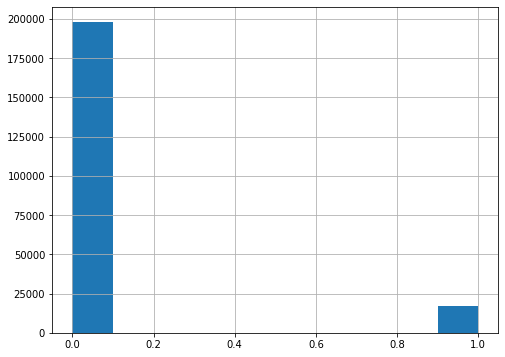

In [223]:
app_train['TARGET'].hist(figsize=(8,6));

1.6. Show the number of columns of each data type.

In [224]:
# Show number of columns per data type
app_train.dtypes.value_counts()

float64    65
int64      42
object     16
dtype: int64

1.7. For categorical variables, show the number of distinct values in each column (number of labels).

In [225]:
# Show number of unique values per categorical column

unique_cat_val = app_train.select_dtypes('object').apply(pd.Series.nunique)
unique_cat_val

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending 

In [226]:
# Checking missing data

# Total missing values 
missing_val = app_train.isna().sum()

# Percentage of missing values 
missing_val_percent = (100 * missing_val / len(app_train)).sort_values(ascending= False)

missing_val_percent[:20]

COMMONAREA_AVG              69.866717
COMMONAREA_MODE             69.866717
COMMONAREA_MEDI             69.866717
NONLIVINGAPARTMENTS_MODE    69.443967
NONLIVINGAPARTMENTS_AVG     69.443967
NONLIVINGAPARTMENTS_MEDI    69.443967
FONDKAPREMONT_MODE          68.391272
LIVINGAPARTMENTS_MODE       68.357359
LIVINGAPARTMENTS_MEDI       68.357359
LIVINGAPARTMENTS_AVG        68.357359
FLOORSMIN_MODE              67.858420
FLOORSMIN_AVG               67.858420
FLOORSMIN_MEDI              67.858420
YEARS_BUILD_AVG             66.501438
YEARS_BUILD_MODE            66.501438
YEARS_BUILD_MEDI            66.501438
OWN_CAR_AGE                 65.975555
LANDAREA_MEDI               59.455906
LANDAREA_MODE               59.455906
LANDAREA_AVG                59.455906
dtype: float64

**Analyzing distribution of variables**

1.9. Show the distribution of credit amounts.

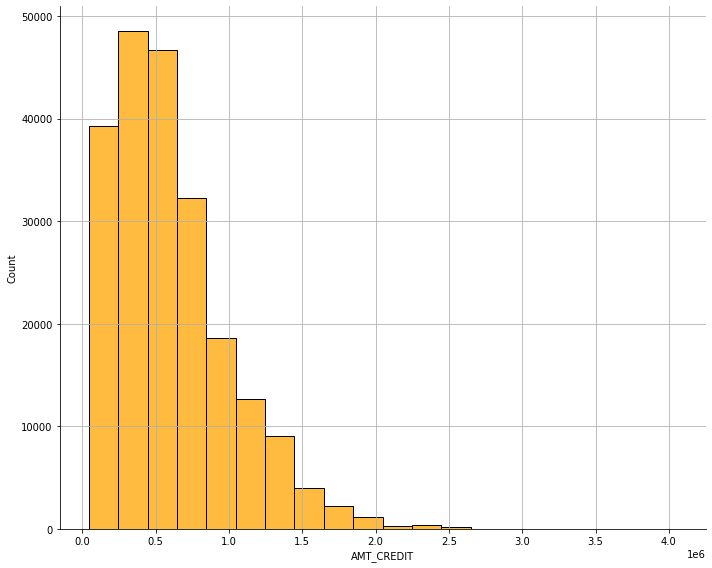

In [227]:
sns.displot(data=app_train, x='AMT_CREDIT',color='orange',bins=20,height=8,aspect= 10/8)
plt.grid();

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

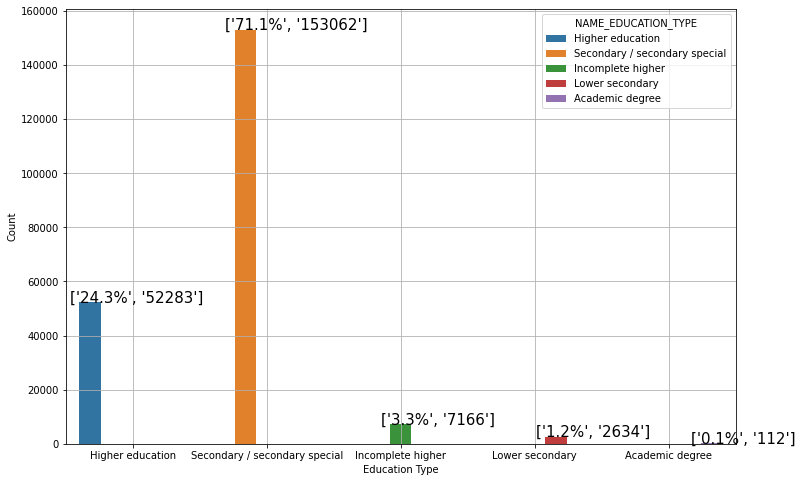

In [228]:
# Level of education plot

#Create a function to show the percentage and total counts of each category.

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = len(feature)

        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            total_each = '{:.0f}'.format(a[(j*Number_of_categories + i)])
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            plot.annotate([percentage,total_each], (x, y), size = 15)
            

    plt.grid()
    plt.show()

plt.figure(figsize=(12,8))
education_plot = sns.countplot(x='NAME_EDUCATION_TYPE', hue="NAME_EDUCATION_TYPE", data=app_train )
education_plot.set(xlabel='Education Type', ylabel='Count')

with_hue(education_plot, app_train['NAME_EDUCATION_TYPE'],5,5)

1.11. Plot the distribution of ocupation of the loan applicants

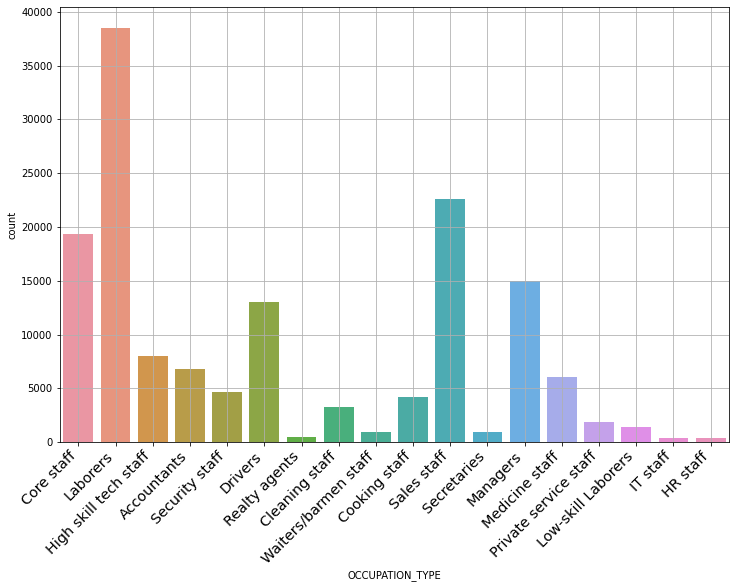

In [229]:
# Ocupation of applicants
plt.figure(figsize=(12,8))
sns.countplot(data= app_train, x='OCCUPATION_TYPE')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.grid();

1.12. Plot the family status of the applicants

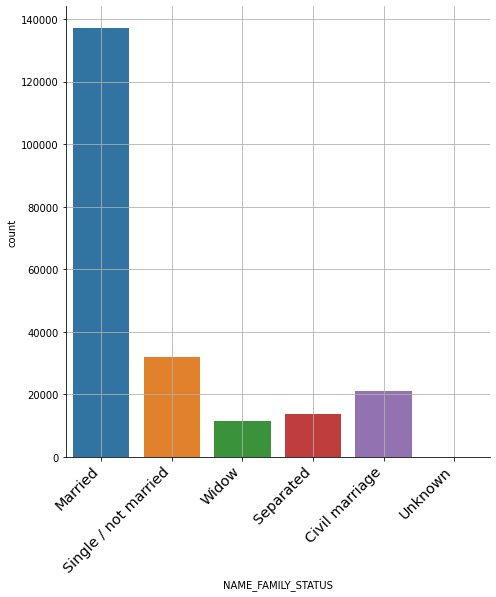

In [230]:
# Family status
sns.catplot(data=app_train, x= 'NAME_FAMILY_STATUS', kind='count', height=7)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.grid();


1.13. Plot the income type of applicants grouped by the target variable

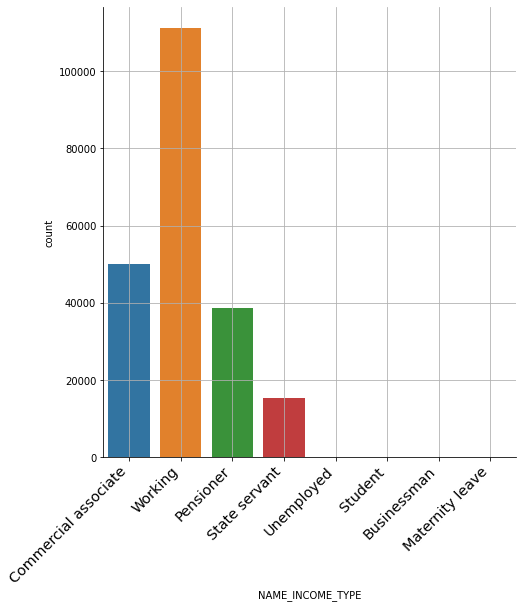

In [231]:
# Income type 
sns.catplot(data=app_train, x='NAME_INCOME_TYPE', kind='count',height=7)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.grid();


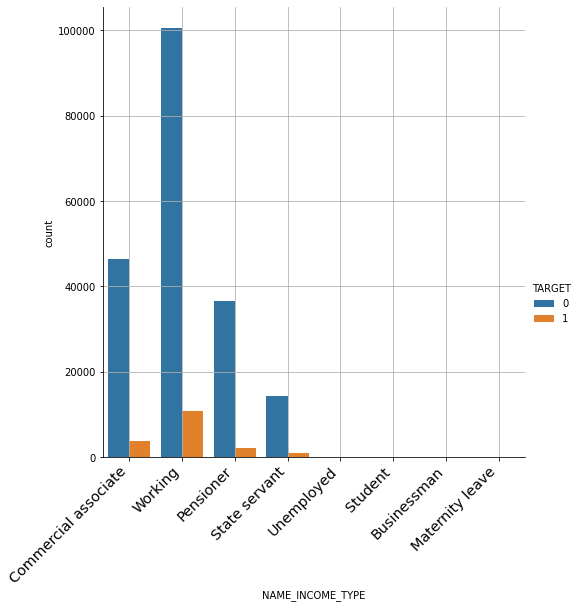

In [232]:
# Income type of applicants by target variable
sns.catplot(data=app_train, x='NAME_INCOME_TYPE', kind='count', hue='TARGET',height=7)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.grid();

## 2. Preprocessing

2.1. The first step will be separate my train and test datasets columns between Features and Targets.

- Assign to `X_train` those columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` those columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).


In [233]:
X_train =app_train.drop(columns=('TARGET'))
y_train =app_train['TARGET'] 
X_test =app_test.drop(columns=('TARGET'))
y_test =app_test['TARGET'] 


2.2. In this section, I will code a function to make all the data pre processing for the dataset. What I do is a function that takes `X_train` and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

In [235]:
# Data pre processing function
def preprocess_data(train_df: pd.DataFrame, test_df: pd.DataFrame): #-> Tuple[np.ndarray, np.ndarray]:
  """
  Pre processes data for modeling. Receives train and testing dataframes 
  for Home Credit Competition, and returns numpy ndarrays of cleaned up 
  dataframes with feature engineering already performed.
  
  Arguments:
      train_df: pd.DataFrame
      test_df: pd.DataFrame
      
  Returns:
      train_data: np.ndarrary
      test_data: np.ndarrary
  """
  
  # I select all numeric and categorical columns and save them in their respective variable.
  columns_num = train_df.select_dtypes(['int','float']).columns
  columns_cat = train_df.select_dtypes('object').columns

  # Create a function to eliminate outliers using the statistical rule (sigma rule).
  def del_outliers(x):
              
      for i in columns_num:
          x_mean = x[i].mean()
          x_std = x[i].std()

          # I will use the sigma rule with 5 standard deviations, because I only want to eliminate the extreme values.
          sd_high =  (x_mean + 5*x_std)

          # Transform all outliers to NaN     
          x[i].loc[x[i] > sd_high] = np.nan
    
      return

  # Clean outliers in app_train.
  del_outliers(train_df)
  train_df['DAYS_EMPLOYED'].replace({365243 : np.nan},inplace=True)

  # Clean outliers in app_test
  del_outliers(test_df)
  test_df['DAYS_EMPLOYED'].replace({365243 : np.nan},inplace=True)


  # Work with missing data in app_train
  imp = SimpleImputer(missing_values=np.nan ,strategy="median")
  train_df[columns_num] = imp.fit_transform(train_df[columns_num])
  test_df[columns_num] = imp.fit_transform(test_df[columns_num])
  
  # Work with missing data in app_test
  imp_object = SimpleImputer(missing_values=np.nan ,strategy="most_frequent")
  train_df[columns_cat] = imp_object.fit_transform(train_df[columns_cat])
  test_df[columns_cat] = imp_object.fit_transform(test_df[columns_cat])

  # Encode the categorical features.
  onehot= OneHotEncoder(sparse=False ,handle_unknown='ignore')
  label_binary = LabelBinarizer()
 

  cat_columns_binary = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']

  
  #Function to encode all categorical columns.
  def get_encode(df):

        #For loop to encode columns with 2 features.    
        for i in cat_columns_binary:
            # I create a Dataframe with the obtained values.  
            temp_df_binary = pd.DataFrame(data = label_binary.fit_transform(df[i]))
            # I give the name to each column.
            temp_df_binary.columns = [i]
            # I remove the original column.
            df.drop(columns=[i], axis=1, inplace=True)
            # Concat the database with the results obtained.
            df = pd.concat([df.reset_index(drop=True), temp_df_binary], axis=1)
                
        # Encode columns with more than 2 features.   
        # I create a Dataframe with the obtained values.

        onehot.fit(df.select_dtypes('object'))
        onehot.fit(df.select_dtypes('object'))
        
        temp_df = pd.DataFrame(data = onehot.transform(df.select_dtypes('object')), columns= onehot.get_feature_names_out())
        
        # I remove the original column.
        df.drop(columns=df.select_dtypes('object').columns, axis=1, inplace=True)

        # Concat the database with the results obtained.
        df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
        
        return df

  # Encode Categorical features in app_train.
  train_df = get_encode(train_df)
  # Encode Categorical features in app_train.
  test_df = get_encode(test_df)

   # Feature Scaling

  scalar = StandardScaler()
  train_df = scalar.fit_transform(train_df)
  test_df = scalar.transform(test_df)

  return train_df, test_df

In [236]:
# This code only shows the percentage of outliers that I converted to nan in each column,
# which is almost equal to 0 so it shows that I only eliminated extreme values.

columns = app_train.select_dtypes(['int','float']).columns

for column in columns:
    x_mean = app_train[column].mean()
    x_std = app_train[column].std()
    
    five_sd = 1 - (norm.cdf(5 * x_std, x_mean, x_std) - norm.cdf(-5 * x_std, x_mean, x_std))
     
    print(f"Fraction of values outside five SD in {column} =", five_sd)
      

Fraction of values outside five SD in Unnamed: 0 = 0.000540499420986662
Fraction of values outside five SD in SK_ID_CURR = 0.010885708840834174
Fraction of values outside five SD in TARGET = 1.3366369638889708e-06
Fraction of values outside five SD in CNT_CHILDREN = 4.91866103802252e-06
Fraction of values outside five SD in AMT_INCOME_TOTAL = 0.00029601355285135966
Fraction of values outside five SD in AMT_CREDIT = 0.00022282647453986115
Fraction of values outside five SD in AMT_ANNUITY = 0.0008644350626259012
Fraction of values outside five SD in AMT_GOODS_PRICE = 0.00019812487871284645
Fraction of values outside five SD in REGION_POPULATION_RELATIVE = 0.00024151209759959436
Fraction of values outside five SD in DAYS_BIRTH = 0.09313450690814595
Fraction of values outside five SD in DAYS_EMPLOYED = 2.7270188630579284e-06
Fraction of values outside five SD in DAYS_REGISTRATION = 0.000167439049651108
Fraction of values outside five SD in DAYS_ID_PUBLISH = 0.0012668807790190417
Fraction o

In the following cell I'm going to execute the functions I've just coded.

In [237]:
train_data, test_data = preprocess_data(X_train, X_test)

## 3. Training Models

As usual, I will start training simple models and will progressively move to more complex models and pipelines.

It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, i going to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell I'm training my model to get an estimate of the time it took to fit my data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters.

In [239]:
# Train a logistic regression, assign to `log_reg` variable
log_regression = LogisticRegression(random_state = 42)


In [240]:
%%timeit
log_reg = log_regression.fit(train_data,y_train)

9.14 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


3.2. Use the trained model to predict probabilities for the test data.

When I using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score I only need the probability that the debt is not repaid (equivalent to class 1).

In [243]:
# Predict test data
log_predict = (log_regression.predict_proba(test_data)[:, 1])

3.3. Get AUC ROC score on test dataset.

In [244]:
# Calculate roc_auc_score.

lr_roc_auc = roc_auc_score(y_test,log_predict)
lr_roc_auc

0.7460979553642683

At this point, the model produce a result around 0.746 

### Training a Random Forest Classifier 

I'm gonna start working in more complex models: ensambles, particularly, I'm going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [69]:
%%timeit
# Train a RandomForestClassifier

rf = RandomForestClassifier(random_state=42) 
rf.fit(train_data,y_train)


2min 12s ± 7.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


3.5. Use the classifier to predict probabilities on the test set.



In [70]:
# Predict test data and store in
random_forest_predict = (rf.predict_proba(test_data)[:, 1])

3.6. Get AUC ROC score on test dataset.

In [71]:
# Calculate roc_auc_score.

rf_roc_auc = roc_auc_score(y_test,random_forest_predict)
rf_roc_auc

0.7048446564031264

At this point, the model produce a result around 0.7

### Randomized Search with Cross Validation

So far, I've only created models using the default hyperparameters of each algorithm. 

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section I trained a random forest classifier and saw how much it took to train it once in your PC. If I want to do hyperparameter optimization I now have to consider that I will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, I can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So I have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because I will have to train each combinations of hyperparameters M number of times, X being the number of folds in which I divided my dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here I'm going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 


3.7. Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier.

In [63]:
# Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier.


random_forest_c = RandomForestClassifier(random_state=42)
param_distributions = {"n_estimators": [10, 100, 200],
                       "criterion": ["gini", "entropy", "log_loss"],
                       "max_depth": [10, 100, 1000],
                       "max_features": ['sqrt',None, 0.2],
                       "class_weight":["balanced",{0:0.2,1:0.8}]
                       }

cv = KFold(n_splits = 5, shuffle=True)  
                         
rf_random = RandomizedSearchCV(random_forest_c, param_distributions, scoring='roc_auc', cv=cv, random_state=42)

In [64]:
#%%timeit

rf_random.fit(train_data,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 0.2, 1: 0.8}],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 100, 1000],
                                        'max_features': ['sqrt', None, 0.2],
                                        'n_estimators': [10, 100, 200]},
                   random_state=42, scoring='roc_auc')

In this model I ran it without the %%timeit because it took a long time, the time it took without the timeit was 617min and 6.2s.

In [65]:
rf_random.best_params_

{'n_estimators': 200,
 'max_features': None,
 'max_depth': 1000,
 'criterion': 'log_loss',
 'class_weight': {0: 0.2, 1: 0.8}}

3.8. Use the classifier to predict probabilities on the test set.


In [66]:
# Predict test data and save csv

rf_predict = (rf_random.predict_proba(test_data)[:, 1])

3.9. Get AUC ROC score on test dataset.

In [67]:
# Calculate roc_auc_score.

rf_tuned_roc_auc = roc_auc_score(y_test,rf_predict)
rf_tuned_roc_auc

0.7341707969960894

At this point, the model produce a result around 0.7341.

3.10. I will train the model for longer iterations, or select more estimator sizes. 

### Training a LightGBM model 

3.11. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. I'll try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers I trained. 

In [246]:
# Train a LightGBM model
lgbm_model = LGBMClassifier(random_state=42) 

In [77]:
%%timeit
lgbm_model.fit(train_data,y_train)

9.58 s ± 577 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
# Calculate roc_auc_score in the LGBM model with default parameters.
lgbm_predict = (lgbm_model.predict_proba(test_data)[:, 1])
lgbm_roc_auc = roc_auc_score(y_test,lgbm_predict)
lgbm_roc_auc

0.7560129666544158

In [92]:

param_distributions = {"objective": ['binary'],
                       "class_weight ":['is_unbalance','scale_pos_weight'] ,
                       "boosting" : ['gbdt'],
                       "num_leaves" :[31,63],
                       "max_depth": [-1,10, 100, 1000],
                       "learning_rate":[0.01,0.1,1]
                       }

cv = KFold(n_splits = 5, shuffle=True) 
lgbm_random = RandomizedSearchCV(lgbm_model, param_distributions, scoring='roc_auc', cv=cv, random_state=42)

In [93]:
%%timeit

lgbm_random.fit(train_data,y_train)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown param

In [99]:
lgbm_random.best_params_

{'objective': 'binary',
 'num_leaves': 31,
 'max_depth': 100,
 'learning_rate': 0.1,
 'class_weight ': 'is_unbalance',
 'boosting': 'gbdt'}

In [211]:
# Calculate roc_auc_score in the LGBM model with the best parameters.
lgbm_predict_best = lgbm_random.predict_proba(test_data)[:, 1]

lgbm_roc_auc_best_param = roc_auc_score(y_test,lgbm_predict_best)
lgbm_roc_auc_best_param

0.7560129666544158

### Using Scikit Learn Pipelines 

3.12. So far I've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and I don't want to have to remember the correct steps to follow each time I have new data to train my models. There are a lots of tools out there that can help I with that, here I can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process my data.

In [214]:
columns_num = X_train.select_dtypes(['int','float']).columns
columns_cat = X_train.select_dtypes('object').columns

In [183]:
def del_outliers(x):
              
      for i in columns_num:
          x_mean = x[i].mean()
          x_std = x[i].std()

          # I will use the sigma rule with 5 standard deviations, because I only want to eliminate the extreme values.
          sd_high =  (x_mean + 5*x_std)

          # Transform all outliers to NaN     
          x[i].loc[x[i] > sd_high] = np.nan
    
      return

# Clean outliers in app_train.
del_outliers(X_train)
X_train['DAYS_EMPLOYED'].replace({365243 : np.nan},inplace=True)

# Clean outliers in app_test
del_outliers(X_test)
X_test['DAYS_EMPLOYED'].replace({365243 : np.nan},inplace=True)

In [206]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


ohe = OneHotEncoder(sparse=False ,handle_unknown='ignore')
Std = StandardScaler()
ohe_bi = OneHotEncoder(drop='if_binary',sparse=False ,handle_unknown='ignore')
imp = SimpleImputer(missing_values=np.nan ,strategy="median")
imp_cat = SimpleImputer(missing_values=np.nan ,strategy="most_frequent")
clf = LGBMClassifier(random_state=42,objective = 'binary',num_leaves = 31, max_depth = 100,learning_rate = 0.1, class_weight ='balanced',
                     boosting = 'gbdt') 


In [247]:
numeric_pipeline = make_pipeline(imp,Std)
categorical_pipeline = make_pipeline(imp_cat,ohe_bi)

pipe = make_column_transformer(
    (numeric_pipeline, columns_num),
    (categorical_pipeline, columns_cat))

LGBM_pipeline = make_pipeline(pipe,clf)

In [248]:
LGBM_pipeline.fit(X_train,y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMP...
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('lgbmclassifier',
                 LGBMClassifier(boosting='gbdt', class_weight='balanced',
                                max_depth=100, objective='binary',
                                random_state=42))])

In [249]:
LGBM_pred =LGBM_pipeline.predict_proba(X_test)[:, 1]

lgbm_roc_auc_best_param_2 = roc_auc_score(y_test,LGBM_pred)
lgbm_roc_auc_best_param_2

0.7552886118136126

In the end the model produces a final result of around 0.755